In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Machine Learning - Aufgabenblatt 4

`sklearn` hat auch ein Neural Network Modell (https://scikit-learn.org/stable/modules/neural_networks_supervised.html), in der Praxis werden aber oft ausgereiftere `Deep Learning` Libraries verwendet, wie `tensorflow` (Google) oder `PyTorch` (Facebook).

Darum verwenden wir für diese Aufgabe `tensorflow` und nicht `sklearn`.

In [2]:
import tensorflow as tf

# random seed fixieren für Musterlösung
tf.random.set_seed(42)

Damit wir Dinge von den vorherigen Aufgabenblätter nicht zu fest wiederholen, haben wir hier bereits den `Datensatz` und eine `Baseline` vorbereitet.

## Datensatz - MNIST

Wir können den Datensatz über `sklearn.datasets.fetch_openml` laden.

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.int32) # Cast string like '1' to integer like 1.

/Users/mebr/PycharmProjects/cas_machine-learning-exercise/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Wir skalieren die Pixelwerte zwischen 0 und 1 (anstatt 0 und 255). Dies ist wichtig für das `Gradient Descent` Lernverfahren.

In [4]:
print("Vorher:", X.max())
X = X / 255  # Sehr einfaches skalieren (oft aussreichend für Bilder)
print("Nach einfachem Skalieren:", X.max())

Vorher: 255.0
Nach einfachem Skalieren: 1.0


Anschliessend teilen wir die Daten wieder in `Train-Set`, `Validation-Set` und `Test-Set`.

In [5]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=5_000, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=5_000, stratify=y_data, random_state=42)

Und wir schauen uns Beispiele dieser handgeschriebenen Zahlen vom `Data-Set` an.

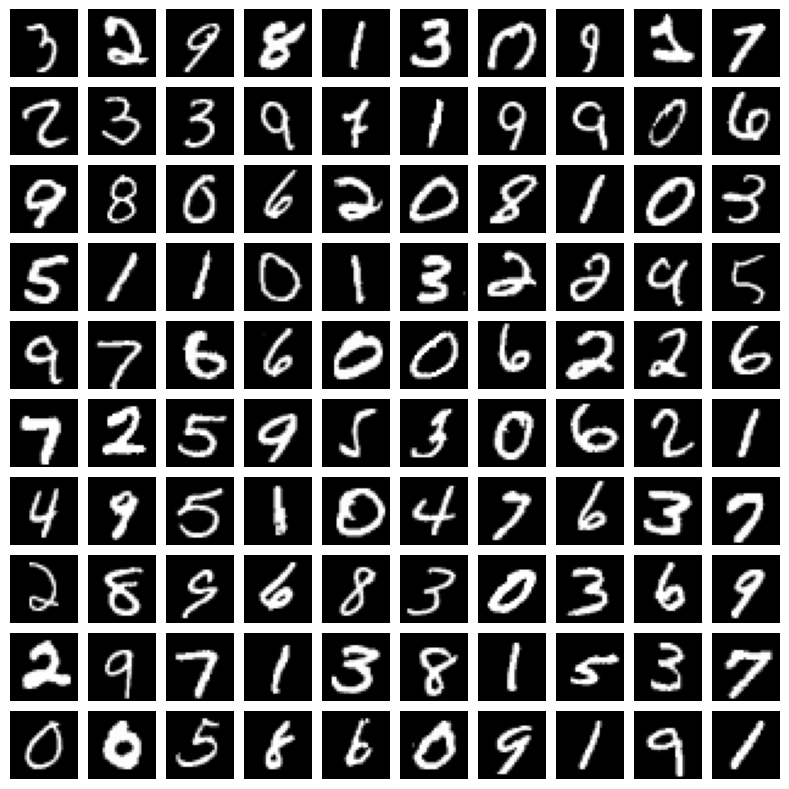

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, X_data.reshape(-1, 28, 28)):
    ax.axis('off')
    ax.imshow(im, cmap='gray')

plt.show()

Wie es bei der `Classification` eigentlich immer Sinn gibt, schauen wir uns die Verteilung der Zielvariable an:

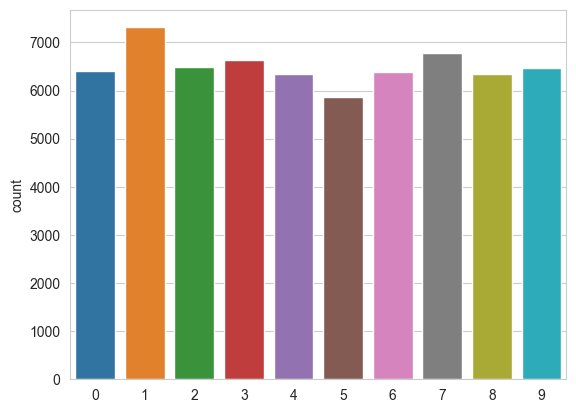

In [7]:
sns.countplot(x=y_data)
plt.show()

Und sehen, dass wir in etwa gleich viele Datenpunkt pro Klasse haben.

## Baseline

Als `Baseline` haben wir hier bereits eine `Logistische Regression` analog zum Aufgabenblatt 3 trainiert und evaluiert.

Wir nehmen allen Pixeln unverändert als Features und fitten das Modell darauf.

Dieses `Baseline`-Modell erreicht eine Genauigkeit von ungefähr 92% - ein bereits ziemlich guter Wert, den wir aber in Aufgabe 2 verbessern werden.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_val_hat = clf.predict(X_val)
print(accuracy_score(y_val_hat, y_val))

0.9254


/Users/mebr/PycharmProjects/cas_machine-learning-exercise/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wie im Aufgabenblatt 3 können wir für diese `Baseline` die `Confusion Matrix` betrachten.

Wir sehen, dass es oft zu Verwechslungen kommt zwischen `7` und `9` oder `5` und `8`. Manche Verwechslungen treten nie auf wie zwischen `0` und `1`.

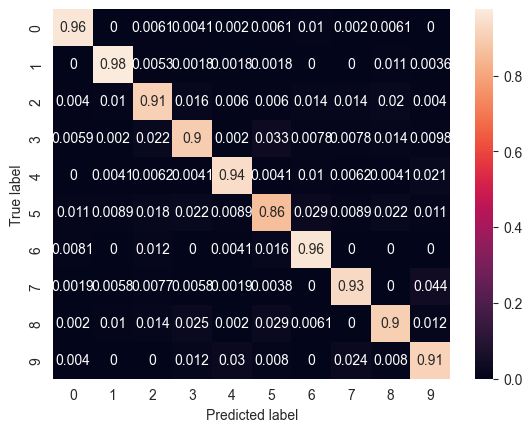

In [10]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, labels=clf.classes_, normalize='true'),
        columns=[clf.classes_], # Name columns
        index=[clf.classes_] # Name rows
    ),
    annot=True # Show numbers in heatmap (not just colors)
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()

## Setup

Folgende Funktion müssen Sie in den Extra-Aufgaben verwenden. Die Umsetzung (der Code) der Funktion muss **nicht** verstanden werden.

In [11]:
from math import sqrt, floor, ceil
from tensorflow.keras import backend as K

def get_2d_dim_of(size):
    n_rows = floor(sqrt(size))
    n_cols = ceil(sqrt(size))
    if n_rows * n_cols < size:
        n_rows = n_rows + 1
    return n_rows, n_cols

def get_alphas_for_weights(weights):
    return np.clip(
        np.abs(weights.reshape(*get_2d_dim_of(weights.shape[0]))),
        a_min=0, a_max=1
    )

def get_alphas_for_weights_list(weights_list, rollaxis=1):
    alphas = []
    for weights in np.rollaxis(weights_list, rollaxis):
        alphas.append(
            get_alphas_for_weights(weights)
        )
    return alphas


from matplotlib.colors import LinearSegmentedColormap, CenteredNorm

c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
red_to_green=LinearSegmentedColormap.from_list('rg',l, N=256)

c = ["darkorange","orange","lightcoral","white", "deepskyblue","blue","darkblue"]
c.reverse()
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
green_to_red=LinearSegmentedColormap.from_list('rg',l, N=256)

def plot_weights(weights: np.array, f = None, alphas=None, colors=None, fig=None, cbar_mode='single', edge_colors=None):

    if alphas is None:
        alphas = itertools.cycle([1])

    if colors is None:
        # colors = itertools.cycle(['viridis'])
        colors = itertools.cycle([red_to_green])

    if edge_colors is None:
        edge_colors = itertools.cycle([None])

    if f is None:
        f = lambda x: x

    if fig is None:
        fig = plt.figure(figsize=(9, 9))

    size = weights.shape[1]
    n_rows = floor(sqrt(size))
    n_cols = ceil(sqrt(size))
    size = weights.shape[0]
    img_n_rows = floor(sqrt(size))
    img_n_cols = ceil(sqrt(size))
    if n_rows * n_cols < size:
        n_rows = n_rows + 1

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
        nrows_ncols=get_2d_dim_of(weights.shape[1]),  # creates 2x2 grid of axes
        axes_pad=(0.1, 0.3),
        share_all=True,
        cbar_location='right',
        cbar_mode=cbar_mode,
        direction = 'row',
        cbar_size='10%',
        cbar_pad=0.1,
    )

    vmin, vmax = weights.min(), weights.max()
    for i, (ax, cax, w, color, edge_color, alpha) in enumerate(zip(grid, grid.cbar_axes, np.rollaxis(weights, 1), colors, edge_colors, alphas)):
        ax.axis('off')
        ax.set_title(f(i))
        im = ax.imshow(w.reshape(*get_2d_dim_of(weights.shape[0])), alpha=alpha, cmap=color, norm=CenteredNorm(halfrange=max(abs(vmin), abs(vmax))))
        # Plot colorbar for im (due to fixed vmin and vmax same for all images)
        cb = plt.colorbar(im, cax=cax)
        cb.set_alpha(1)
        if edge_color is not None:
            pass
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth('2')
        cb.draw_all()

    return fig


def get_layer_activations_for(model, input_img):
    """
    Hilfsfunktion für die Berechnung der Aktivierungen von allen Layern in unserem Neuralen Netz.
    """
    input_data = input_img.reshape(1, -1)
    outputs = [K.function([model.get_layer(index=0).input], layer.output)([input_data]).reshape(-1) for layer in model.layers]
    return input_img, *outputs

## Aufgabe 1 - Logistische Regression als Neural Network

In Aufgabe 1 bauen wir die `Logistische Regression` (die `Baseline` aus der Aufgabenbeschreibung) als `Neurales Netzwerk` nach. Anschliessend trainieren und evaluieren wir das Netzwerk.

Dieses `Neurales Netzwerk` hat noch keinen `Hidden Layer` und ist dadurch ein lineares Modell. Es entspricht (bis auf wie es trainiert wird) der `Logistischen Regression` von `sklearn` und wir erwarten daher in Aufgabe 1 (noch) keine Verbesserung zur `Baseline`.

In der Aufgabe 2 schauen wir uns dann ein `Neurales Netz` mit einem `Hidden Layer` mit nicht linearer Aktivierungsfunktion an - ein nicht lineares Modell.

### Aufgabe 1.1 - Logistische Regression als (Feed Forward) Neural Network

1. Erstellen Sie ein sequenzielles Neurales Netzwerk mittels `tf.keras.Sequential`
2. Fügen Sie einen Input Layer `tf.keras.layers.InputLayer` mit der shape `input_shape=(28*28,)` hinzu mittels `model.add`.
3. Fügen Sie einen Output Layer `tf.keras.layers.Dense` mit `units=10` und der Softmax Aktivierungsfunktion `activation=tf.keras.activations.softmax` hinzu mittels `model.add`.
4. Geben Sie eine Beschreibung des Modell mittels `print(model.summary())` aus. Das Modell sollte 7850 totale Parameter haben.
5. (Extra) Rechnen Sie die Anzahl Parameter von Hand nach.

Zur Illustration ist das Neurale Netzwerk von Aufgabe 1 hier grafisch abgebildet. Es hat 784 Inputs ($x_1$, ..., $x_{784}$) für jeden Pixel ein Input (28 * 28 = 784) und 10 Ouputs ($\hat y_0$, ..., $\hat y_9$) für jede `Klasse` (Ziffer) einen Output.

![Logistische Regression als Neural Network](./img/logistic-regression-as-nn-mnist.png)


#### Hilfreiche Links

* tf.keras.Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [12]:
import tensorflow as tf

# Neural Network ohne Hidden Layer
# 1.
model = tf.keras.Sequential()
# 2. 
model.add(tf.keras.layers.InputLayer(input_shape=(28*28,), name='input_layer'))
# 3.
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'))

# 4.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


5\.
Wir haben für jeden Input ($x_1$ bis $x_{784}$) und für den Bias ($x_0$) jeweils einen Verbindung (Pfeil) zu jedem Output ($\hat y_0$ bis $\hat y_9$).
Für jede Verbindung haben wird ein Parameter (Gewicht): 
$\text{Anzahl Verbindungen} = (\text{Inputs} + \text{Bias}) * \text{Ouputs} = (784 + 1) * 10 = 7850 = \text{Total Parameter} $

### Aufgabe 1.2 - `model.compile`, `model.fit`

In Aufgabe 1.1 haben wir das Netzwerk erstellt und mit `model.summary()` überprüft.

Nun möchten wir das Modell trainieren (`fit`).

Dazu müssen wir dem Modell mitteilen, welches Optimierungsverfahren (`optimizer`) und welche Kostenfunktion (`loss`) wir für das Training verwenden möchten.

In der `Logistischen Regression` von `sklearn` sind diese Werte im Modell hard-codiert vorgegeben und man kann sie nicht überschreiben. 
`Neurale Netze` von `tensorflow` können mit unterschiedlichen Kostenfunktionen (`tf.keras.losses`) und unterschiedlichen Optimiertungsverfahren (z.B. `adam`) trainiert werden. Darum muss man diese Werte für ein `tensorflow` Modell noch angeben.

1. Erstellen Sie eine `tf.keras.losses.SparseCategoricalCrossentropy` Funktion mit `from_logits=False`.
2. Kompilieren Sie das Modell mit `model.compile`. Geben Sie die `loss` Funktion und den `optimizer` an. Für den `optimizer` können Sie `sgd` für das `Batch Gradient Descent` Verfahren oder `adam` für `Adam` ein verbessertes `Batch Gradient Descent` Verfahren.
3. Trainieren Sie das Modell mittels `model.fit`. Wir müssen eine Batch Size `batch_size=64` und die Anzahl Epochen `epochs=15` mitgeben:
    - `batch_size`: Wie viele Datenpunkte werden für einen Schritt im `Batch Gradient Descent` Verfahren verwendet.
    - `epochs`: Wie oft iterieren wir über das gesamte `Train-Set`.
4. Berechnen Sie die Wahrscheinlichkeiten der Klassen `y_val_hat_prob` auf dem `Validation-Set` (`X_val`) mittels `model.predict`.
    - Anders als die Logistische Regression gibt uns `model.predict` hier 10 Outputs, **die Wahrscheinlichkeiten** für jede `Klasse`.
5. Holen Sie die tatsächliche Vorhersagen `y_val_hat` aus den Wahrscheinlichkeiten `y_val_hat_prob` aus Schritt 2. Die tatsächliche Vorhersage ist der Output mit dem grössten Wert (der grösste Wahrscheinlichkeit).
    - Nutzen Sie dazu `np.argmax` über die zweite Achse `axis=1`.
    - Geben Sie die `shape` von `y_val_hat_prob` und von `y_val_hat` aus, um besser zu verstehen, was wir genau machen.
6. Berechnen Sie die Genauigkeit unseres Modelles mittels `accuracy_score`.
7. Berechnen Sie die Confusion Matrix mittels `confusion_matrix`.

In [13]:
# 1.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# 2.
model.compile(
    optimizer='adam', # adam ist eine Form von Stochastic Gradient Descent mit extra Schritten, damit das Netzwerk schneller lernt.
    loss=loss_fn,    
    metrics=['accuracy'] # Metrik können für das Ausgeben von zwischen Ergebnissen angegeben werden
)

In [14]:
# 3. Wir speichern noch die `fit`-history, um sie in anschliessend zu plotten.
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15


2023-05-01 13:57:40.791328: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


938/938 [==============================] - 1s 720us/step - loss: 0.5438 - accuracy: 0.8642 - val_loss: 0.3529 - val_accuracy: 0.9062
Epoch 2/15
938/938 [==============================] - 1s 544us/step - loss: 0.3222 - accuracy: 0.9117 - val_loss: 0.3111 - val_accuracy: 0.9166
Epoch 3/15
938/938 [==============================] - 1s 590us/step - loss: 0.2948 - accuracy: 0.9177 - val_loss: 0.2956 - val_accuracy: 0.9202
Epoch 4/15
938/938 [==============================] - 1s 617us/step - loss: 0.2809 - accuracy: 0.9217 - val_loss: 0.2869 - val_accuracy: 0.9252
Epoch 5/15
938/938 [==============================] - 1s 596us/step - loss: 0.2725 - accuracy: 0.9242 - val_loss: 0.2876 - val_accuracy: 0.9216
Epoch 6/15
938/938 [==============================] - 1s 591us/step - loss: 0.2666 - accuracy: 0.9261 - val_loss: 0.2828 - val_accuracy: 0.9258
Epoch 7/15
938/938 [==============================] - 1s 595us/step - loss: 0.2626 - accuracy: 0.9269 - val_loss: 0.2783 - val_accuracy: 0.9260
Epo

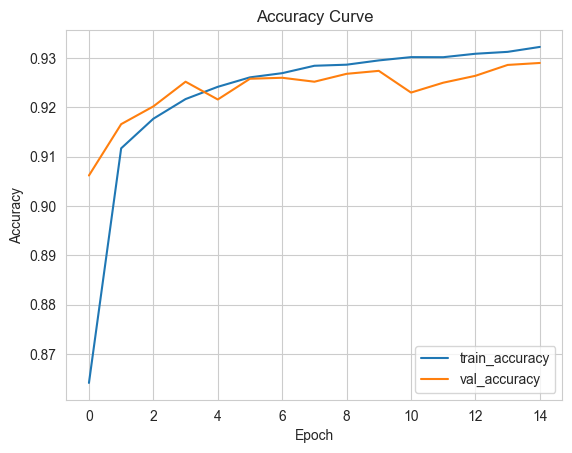

In [15]:
# Plotten der History: Zeigt den Verlauf des Trainings über die Anzahl Epochen. (Nicht Teil der Aufgabe)
# Hierfür muss bei `model.compile` di `accuracy` Metrik und bei fit das `Validation-Set` mitgegeben worden sein.
plt.title('Accuracy Curve')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# 4.
y_val_hat_prob = model.predict(X_val)
# 5.
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print("y_val_hat_prob.shape: ", y_val_hat_prob.shape)
print("y_val_hat.shape: ", y_val_hat.shape)

# 6.
print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 417us/step
y_val_hat_prob.shape:  (5000, 10)
y_val_hat.shape:  (5000,)
0.929


Die `Accuracy` unseres `Neuralen Netzwerkes` **ohne** `Hidden Layer` entspricht in etwa der Performanz der `Logistischen Regression`, was, wie oben beschrieben, zu erwarten war. 

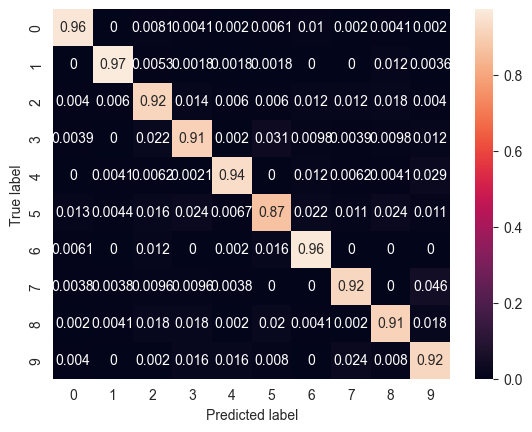

In [17]:
# 7.
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, labels=clf.classes_, normalize="true"),
        columns=[clf.classes_], # Name columns
        index=[clf.classes_] # Name rows
    ),
    annot=True # Show numbers in heatmap (not just colors)
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()

### (Extra) Aufgabe 1.3 - Was wurde gelernt?

Wir können die gelernten Parameter (Gewichte) vom `Neuralen Netz` grafisch betrachten, um eine Intuition zu entwickeln, was das `Neurale Netz` lernt.

Hier lesen wir mittels `model.get_weights()[0]` die Parameter vom Modell aus und stellen sie mittels der mitgelieferten Funktion `plot_weights` grafisch dar.

/var/folders/r4/qv73kqy57n311vs5d2vsggln0kzcwf/T/ipykernel_90301/1087055252.py:89: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


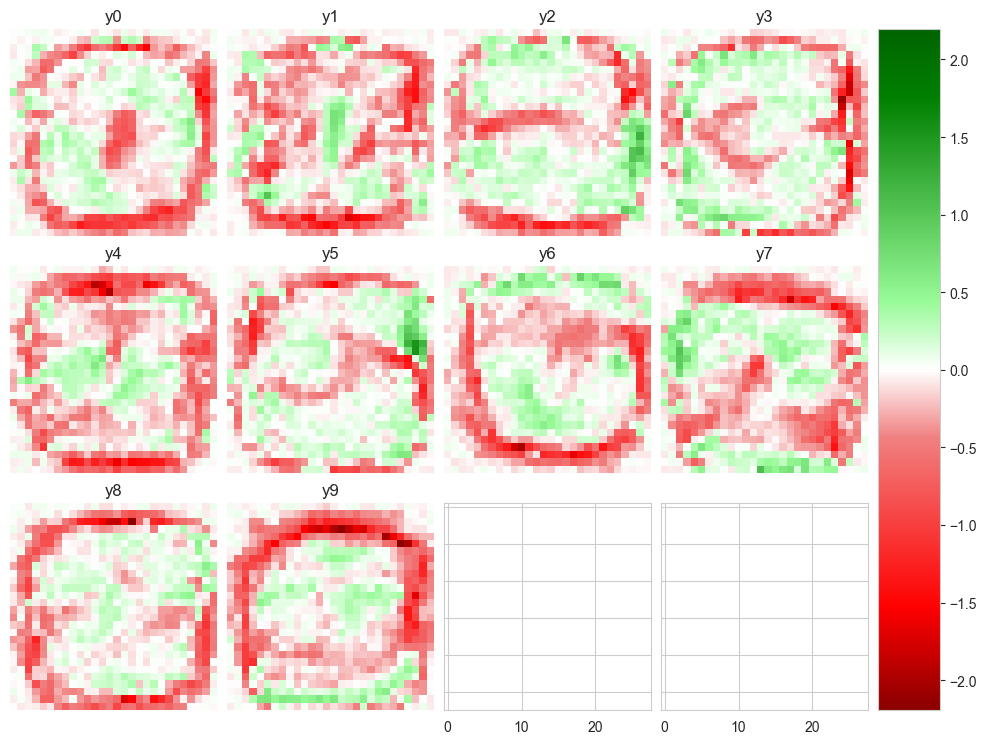

In [18]:
fig = plt.figure(figsize=(12, 12))
plot_weights(model.get_weights()[0], lambda i: f'y{i}', fig=fig)
plt.title("Gelernte Gewichte")
plt.show()

Das Bild `y0` ist hier das Output Neuron der Ziffer `0` ($\hat y_0$) und entspricht den hier rot dargestellten Parameter ($\theta^{(1)}_{0,1}$, ... $\theta^{(1)}_{0,784}$).

![Logistische Regression: Gewichte](./img/logistic-regression-as-nn-mnist-weights.png)

`plot_weights` zeigt die Parameter (Verbindungen) von allen 784 Pixeln ($x_1$, ..., $x_{784}$) zu jedem Output Neuron ($\hat y_0$, ..., $\hat y_9$).
Wir haben 10 Output Neuronen, also 10 Bilder mit 784 Parameters. Die 784 Parameter werden als 28*28 Bild dargestellt.

Man kann sich die gelernten Gewichte als eine Maske vorstellen, die wir über das ursprüngliche Bild legen und anschliessend die Werte aufsummieren.
Ein positiver Wert der Maske bedeutet, dass eine Aktivierung dieses Pixel **für** die `Klasse` des Outputs spricht.
Ein negativer Wert der Maske bedeutet, dass eine Aktivierung dieses Pixel **gegen** die `Klasse` des Outputs spricht.

1. Interpretieren Sie die dargestellten Gewichte vom Bild `y0`.

1\.

Die Maske `y0` hat negative Gewichte in der Mitte des Bildes. Aktive Pixel in der Mitte des Input-Bild sprechen also **gegen** die `Klasse` `0`.
Pixel um die Mitte des Input-Bild (in einer `0` Form :-)) sprechen für die `Klasse` `0`.

Beachten Sie, dass diese Masken jeden Pixel (Input) **unabhängig von allen anderen Pixel gewichten**.
Es kann zu **keiner Interaktion zwischen den Pixel** (zwischen den Inputs) kommen!
Anders ausgedrückt: Der Wert eines Outputs ist eine gewichtete Summe aller Pixel (aller Inputs).
Eine gewichtete Summe der Inputs ist nichts anderes als ein Lineares Modell.

In Aufgabe 2 werden wir ein Hidden Layer hinzufügen und somit **Interaktionen zwischen Pixel (zwischen Inputs) möglich machen**.
Das Modell wird damit nicht-linear und ist flexibler.
Da wir genügend Daten haben, um die Flexibilität des Modelles intelligent zu nutzen, sprich wir nicht `Overfitten`, ist das Modell aus Aufgabe 2 dann auch besser als dieses Modell.

Man kann sich die gelernten Gewichte als Maske vorstellen, die wir jeweils über das Input-Bild legen. Die Aufsummierung der jeweils aktiven Gewichte ist dann die Aktivierung für die jeweilige Klasse. Das Ganze ist hier grafisch dargestellt.

/var/folders/r4/qv73kqy57n311vs5d2vsggln0kzcwf/T/ipykernel_90301/1087055252.py:89: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


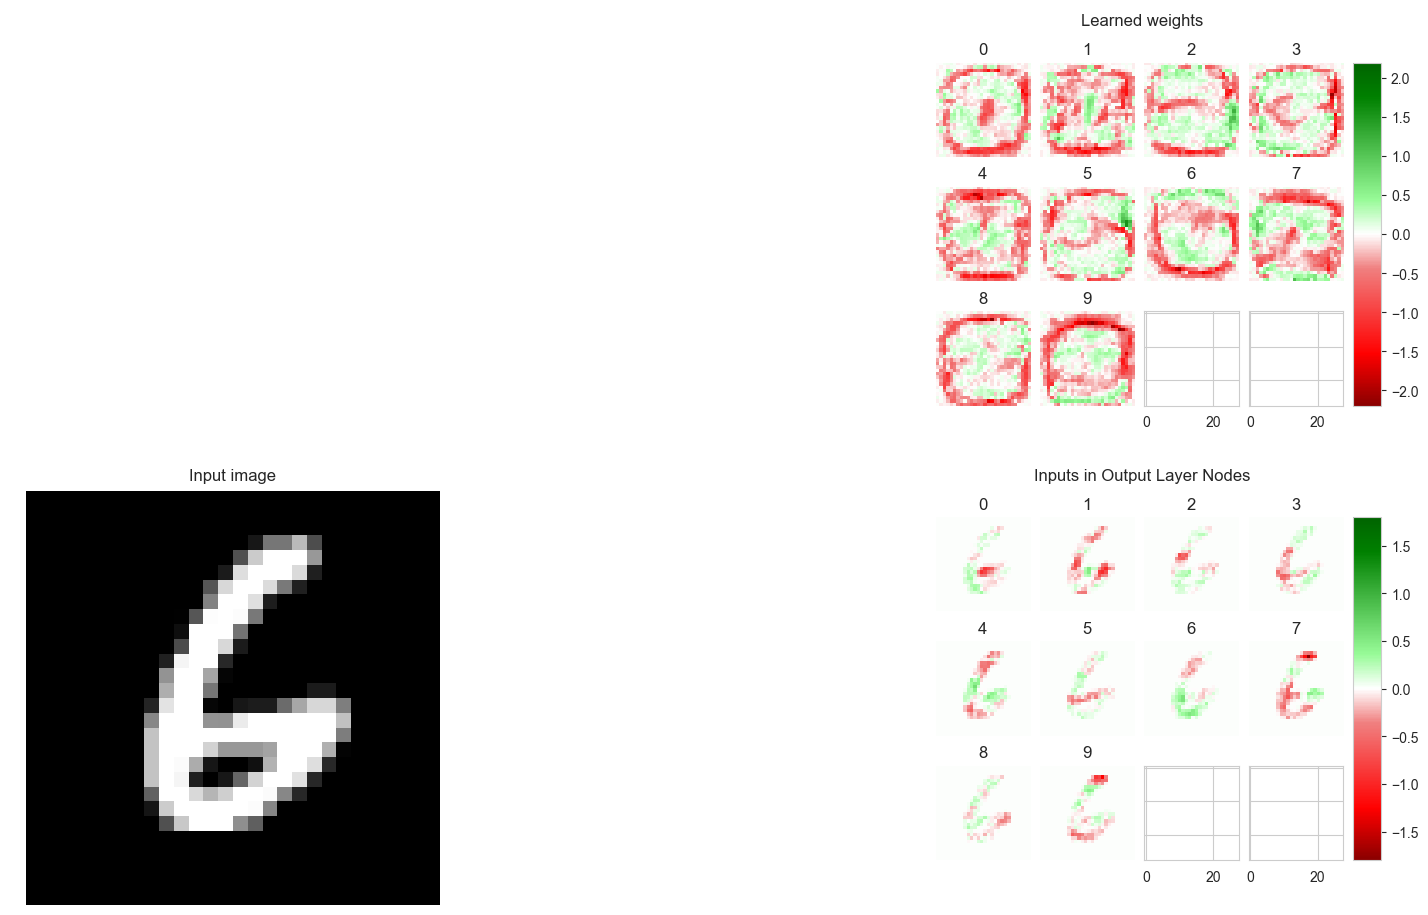

In [19]:
image_index = 1

# Berechnung der Aktivierungen innerhalb des Neuralen Netzes für spätere plots.
input_layer_output, output_layer_output = get_layer_activations_for(model, X_val[image_index, :])

hidden_layer_pre_output = (model.get_weights()[0].T * input_layer_output).T

fig = plt.figure(constrained_layout=True, figsize=(18, 9))
subfigs = fig.subfigures(2, 2, width_ratios=[1, 3])

plot_weights(model.get_weights()[0], fig=subfigs[0][1]) \
    .suptitle(f"Learned weights")

ax = subfigs[1][0].subplots(1, 1)
subfigs[1][0].suptitle("Input image")
ax.imshow(input_layer_output.reshape(28, 28), cmap='gray')
ax.axis('off')

output_layer_pre_output = (model.get_weights()[0].T * input_layer_output).T

plot_weights(output_layer_pre_output, fig=subfigs[1][1]) \
    .suptitle(f"Inputs in Output Layer Nodes")
plt.show()


### Schlusswort Aufgabe 1

In der Aufgabe 1 haben wir eine `Logistische Regression` als `Neurales Netzwerk` "nachgebaut", trainiert und evaluiert.

Praktisch macht dies nicht wirklich Sinn, da wir längere Traininszeit hatten, aber keine Verbesserung im Resultat.
Das Modell ist ähnlich der `LogisticRegression` im Setup des Aufgabenblattes.

Wir haben dafür `tensorflow` kennengelernt und können in Aufgabe 2 unser neues Wissen nutzen und ein `Neurales Netz` mit einem `Hidden Layer` entwickeln.

### Aufgabe 2

#### Aufgabe 2.1 - (Fully-Connected) Neural Network mit einem Hidden Layer

Ziel dieser Aufgabe ist es folgendes Neurales Netzwerk zu bauen:

![One-Hidden-Layer (mit 36 Neuronen) Neural Network für MNIST](./img/nn-one-hidden-mnist.png)

1. Erstellen Sie das dargestellte Neurale Netzwerk. Achten Sie darauf, dass der `Hidden Layer` eine `Aktivierungsfunktion` mittels dem Parameter `activation` benötigt. Verwenden Sie `tf.keras.activations.relu` oder `tf.keras.activations.gelu`. Der Hidden Layer hat 36 Neuronen `units=36`. In der Praxis nimmt man eher eine Zweierpotzent wie 32, 64 oder 128 (aus Performanzgründen).
2. Geben Sie eine Beschreibung des Modell mittels `print(model.summary())` aus. Das Modell sollte **28'630 totale Parameter** haben.
3. Kompilieren Sie das Modell analog zur Aufgabe 1.
4. Trainieren Sie das Modell auf dem `Train-Set`.
5. Evaluieren Sie das Modell auf dem `Validation-Set`.

In [35]:
# 1. Neural Network mit einem Hidden Layer
model_with_hl = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28*28,), name='input_layer'),
    tf.keras.layers.Dense(36, activation=tf.keras.activations.gelu, name='hidden_layer'),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'),
])

# 2. 
print(model_with_hl.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 36)                28260     
                                                                 
 output_layer (Dense)        (None, 10)                370       
                                                                 
Total params: 28,630
Trainable params: 28,630
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# 3.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_with_hl.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [37]:
# 4.
history = model_with_hl.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
938/938 [==============================] - 1s 781us/step - loss: 0.3975 - accuracy: 0.8875 - val_loss: 0.2566 - val_accuracy: 0.9286
Epoch 2/15
938/938 [==============================] - 1s 686us/step - loss: 0.2192 - accuracy: 0.9367 - val_loss: 0.2001 - val_accuracy: 0.9428
Epoch 3/15
938/938 [==============================] - 1s 706us/step - loss: 0.1707 - accuracy: 0.9500 - val_loss: 0.1706 - val_accuracy: 0.9488
Epoch 4/15
938/938 [==============================] - 1s 700us/step - loss: 0.1401 - accuracy: 0.9586 - val_loss: 0.1453 - val_accuracy: 0.9548
Epoch 5/15
938/938 [==============================] - 1s 701us/step - loss: 0.1203 - accuracy: 0.9647 - val_loss: 0.1425 - val_accuracy: 0.9566
Epoch 6/15
938/938 [==============================] - 1s 729us/step - loss: 0.1062 - accuracy: 0.9685 - val_loss: 0.1298 - val_accuracy: 0.9602
Epoch 7/15
938/938 [==============================] - 1s 853us/step - loss: 0.0942 - accuracy: 0.9725 - val_loss: 0.1176 - val_accuracy:

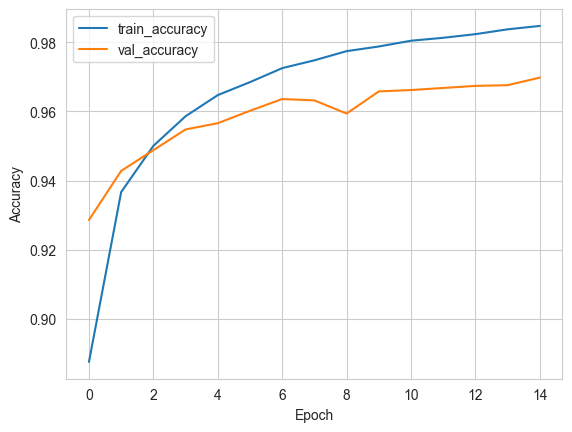

In [38]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# 5.
y_val_hat_prob = model_with_hl.predict(X_val)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 476us/step
0.9698


Es kam mit einer Genauigkeit von 95% zu einer Verbesserung gegenüber Aufgabe 1, wo wir eine Genauigkeit von 92% erzielten.

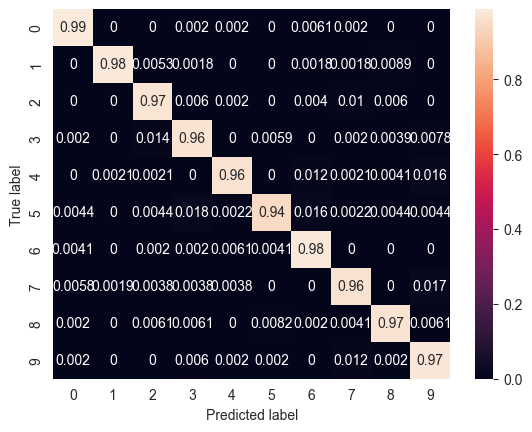

In [40]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, labels=clf.classes_, normalize='true'),
        columns=[clf.classes_], # Name columns
        index=[clf.classes_] # Name rows
    ),
    annot=True # Show numbers in heatmap (not just colors)
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()

### (Extra) Aufgabe 2.2 - Was wurde gelernt?

Nun versuchen wir wieder zu verstehen, was für Gewichte gelernt wurden.

#### (Extra) Aufgabe 2.2.1 - Input Layer zu Hidden Layer

Wir schauen uns zuerst die Gewichte zwischen dem `Input Layer` und dem `Hidden Layer` an.
Beispielsweise für die Verbindungen vom Input Layer ($x_1$, ..., $x_{784}$) zum Neuron $z_1$ haben wir die Gewichte $\theta^{(1)}_{1,1}$, ..., $\theta^{(1)}_{1,784}$ (hier rot dargestellt).

![](./img/nn-one-hidden-mnist-weights-1.png)

Mit der Funktion `plot_weights` sind hier die Gewichte von den ersten Verbindungen (`model.get_weights()[0]`) vom Input Layer zum Hidden Layer dargestellt analog zur Aufgabe 1.3.

1. Warum sind es jetzt 36 Masken anstatt 10 Masken? 
2. Können Sie sonst noch etwas erkennnen? Warum erkennt man anders als in Aufgabe 1.3 hier keine klaren Zahlen-Masken?

/var/folders/r4/qv73kqy57n311vs5d2vsggln0kzcwf/T/ipykernel_90301/1087055252.py:89: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


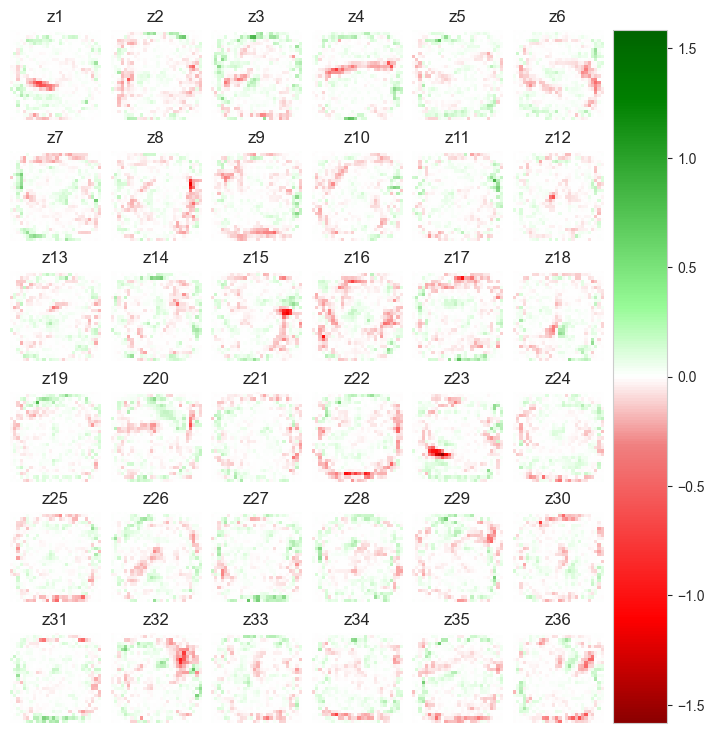

In [41]:
alphas = get_alphas_for_weights_list(model_with_hl.get_weights()[0])
plot_weights(model_with_hl.get_weights()[0], lambda i: f'z{i+1}', alphas=alphas)
plt.show()

In [42]:
print(model_with_hl.get_weights()[0].shape)

(784, 36)


1\.
Anders als in Aufgabe 1.3 gehen wir hier nicht direkt zum Output Layer (10 Neuronen) sondern zuerst zum Hidden Layer (36 Neuronen).
Also haben wir vom Input Layer (784) zum Hidden Layer (36) 36 mal 784 Verbindungen oder anders gesagt 36 Bilder von 28 * 28 Pixel.

In [43]:
print("Shape der Gewichte", model_with_hl.get_weights()[0].shape)

Shape der Gewichte (784, 36)


2\.
Der Hidden Layer kann als automatisches `Feature Engineering` verstanden werden. Das `Neurale Netz` lernt anhand der Daten in den Input Bildern Strukturen zu erkennen, die es für die Classification **im Output Layer verwenden** kann. Die hier dargestellte Masken sind also `Feature Extractors`, also wir reduzieren die 784 Pixel (Input-Features) zu 36 neue (Latent-)Features. Diese Features sind beispielsweise aktiv, wenn eine gewisse Region im Ursprungsbild aktiv ist.
Diese 36 neuen Features werden dann im zweiten Layer (Hidden Layer zu Output Layer) verwendet, um vorherzusagen um welche Ziffer es sich handelt.

#### (Extra) Aufgabe 2.2.2 - Hidden Layer zu Output Layer

Jetzt schauen wir uns die Gewichte zwischen dem Hidden Layer und dem Output Layer an.
Diese Gewichte gewichten die 36 Features vom gelernten `Feature Engineering` um vorherzusagen, um welche Ziffer es sich beim ursprünglichen Input handelte. 

Beispielsweise für die Verbindungen vom Hidden Layer ($z_1$, ..., $z_{36}$) zum Output Neuron $\hat y_0$ haben wir die Gewichte $\theta^{(2)}_{0,1}$, ..., $\theta^{(2)}_{0,36}$ (hier rot dargestellt).

![](./img/nn-one-hidden-mnist-weights-2.png)

Mit der Funktion `plot_weights` sind hier die Gewichte von den Verbindungen (`model.get_weights()[2]`) vom Hidden Layer zum Output Layer dargestellt analog zur Aufgabe 2.2.1.

1. Warum sehen Sie so strukturlos aus? Was bedeuten diese Gewichte? 

(36, 10)


/var/folders/r4/qv73kqy57n311vs5d2vsggln0kzcwf/T/ipykernel_90301/1087055252.py:89: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


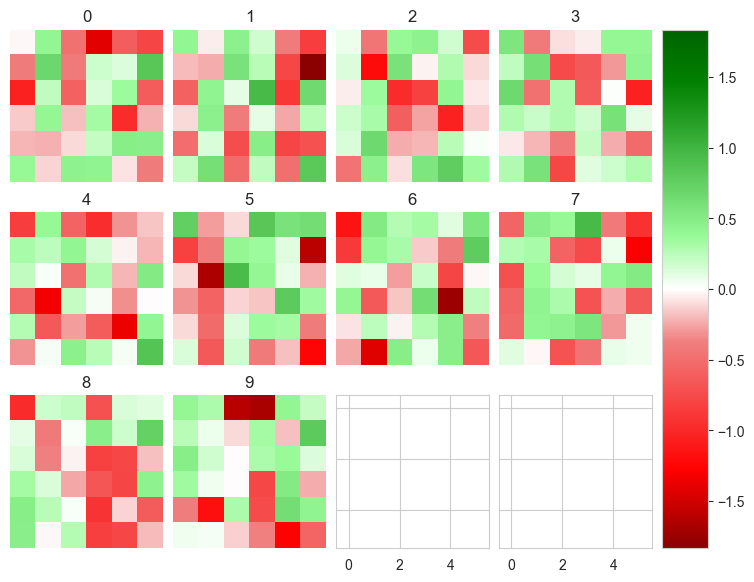

In [44]:
print(model_with_hl.get_weights()[2].shape)
plot_weights(model_with_hl.get_weights()[2])
plt.show()

1\.
Wir erkennen kein klares Muster in den Gewichten. Die 36 Gewichte bestimmen welches der 36 gelernten Feature im Hidden Layer (vom automatischen `Feature Engineering` beschrieben in der Musterlösung von Aufgabe 2.2.1) wie stark gewichtet werden. Die gelernten Features haben keine bestimmte Reihenfolge, darum haben die Gewichte auch keine klare Struktur.
Ein negativer Wert eines Gewichtes bedeutet, dass dieses Feature gegen den Output spricht. Ein positiver Wert eines Gewichtes bedeutet, dass dieses Feature für den Ouput spricht. (Die Features sind wegen der ReLU (oder GeLU) Aktivierungsfunktion immer positive).

#### (Extra) Aufgabe 2.2.3 - Input Layer zu Output Layer

Bis jetzt haben wir die beiden Layer getrennt betrachtet. 

Jetzt möchten wir die beiden Layers gemeinsam betrachten, indem wir die 36 gelernten Features anhand der `Input Layer` `Hidden Layer` Gewichte beschreiben, und schauen für ein Input Bild welches dieser Feature wie stark für und gegen eine bestimmte Klasse spricht.

Dazu wird hier folgendes gemacht.
Wir betrachten die Neuronen im Hidden Layer ($z_1$, ..., $z_36$) als Gewichtsmasken ($\theta^{(1)}_{1,1}$, ..., $\theta^{(1)}_{1,784})$ analog zur Aufgabe 2.2.1. 
Zuerst schauen wir uns ein Input Image (Bild 1) an (definiert durch `image_index`).
Dann schauen wir uns zuerst die Aktivierungen dieser "Features" ($z_1$, ..., $z_36$) an (Bild 2). Stark aktive Features werden opak dargestellt, schwach aktive Features werden transparent dargestellt.
Anschliessend gewichten wir die Features nach dem Gewicht zu einem bestimmten Ouput (z.B. $\hat y_0$) - Gewichte dargestellt in Aufgabe 2.2.2.
Negative Werte bedeuten dieses "Feature" spricht gegen die Ziffer (rot). Positive Werte bedeuten dieses "Feature" spricht für die Ziffer (grün).
Wie stark ein Feature aktiv ist wird wieder über die Transparenz angezeigt.

1. Studieren Sie die Plots unten.
2. Was erkennen Sie in den Plots? Wie unterscheiden sich die falschen Klassen von der richtigen Klasse?

3


/var/folders/r4/qv73kqy57n311vs5d2vsggln0kzcwf/T/ipykernel_90301/1087055252.py:89: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


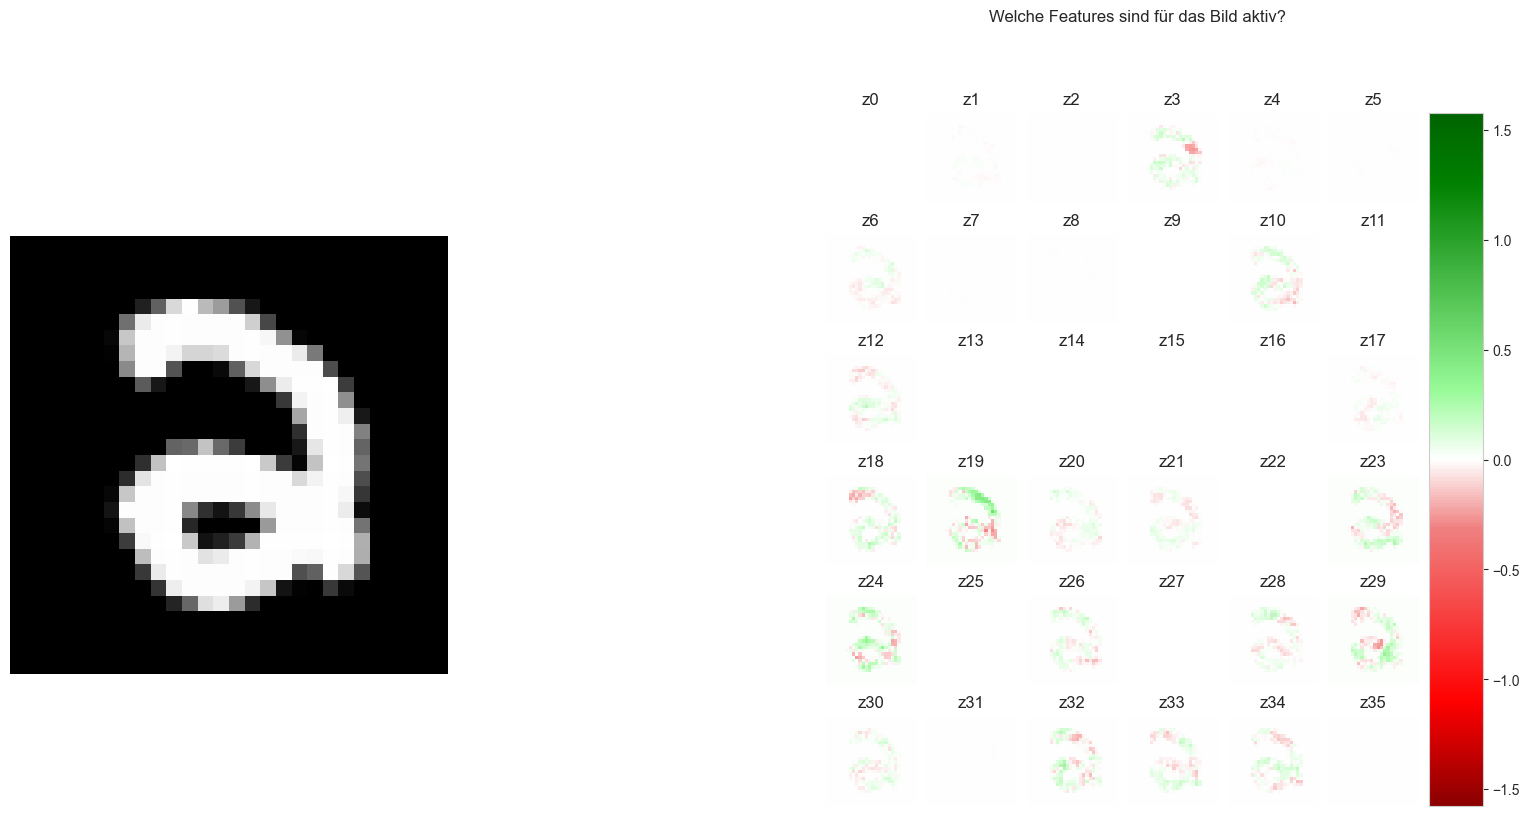

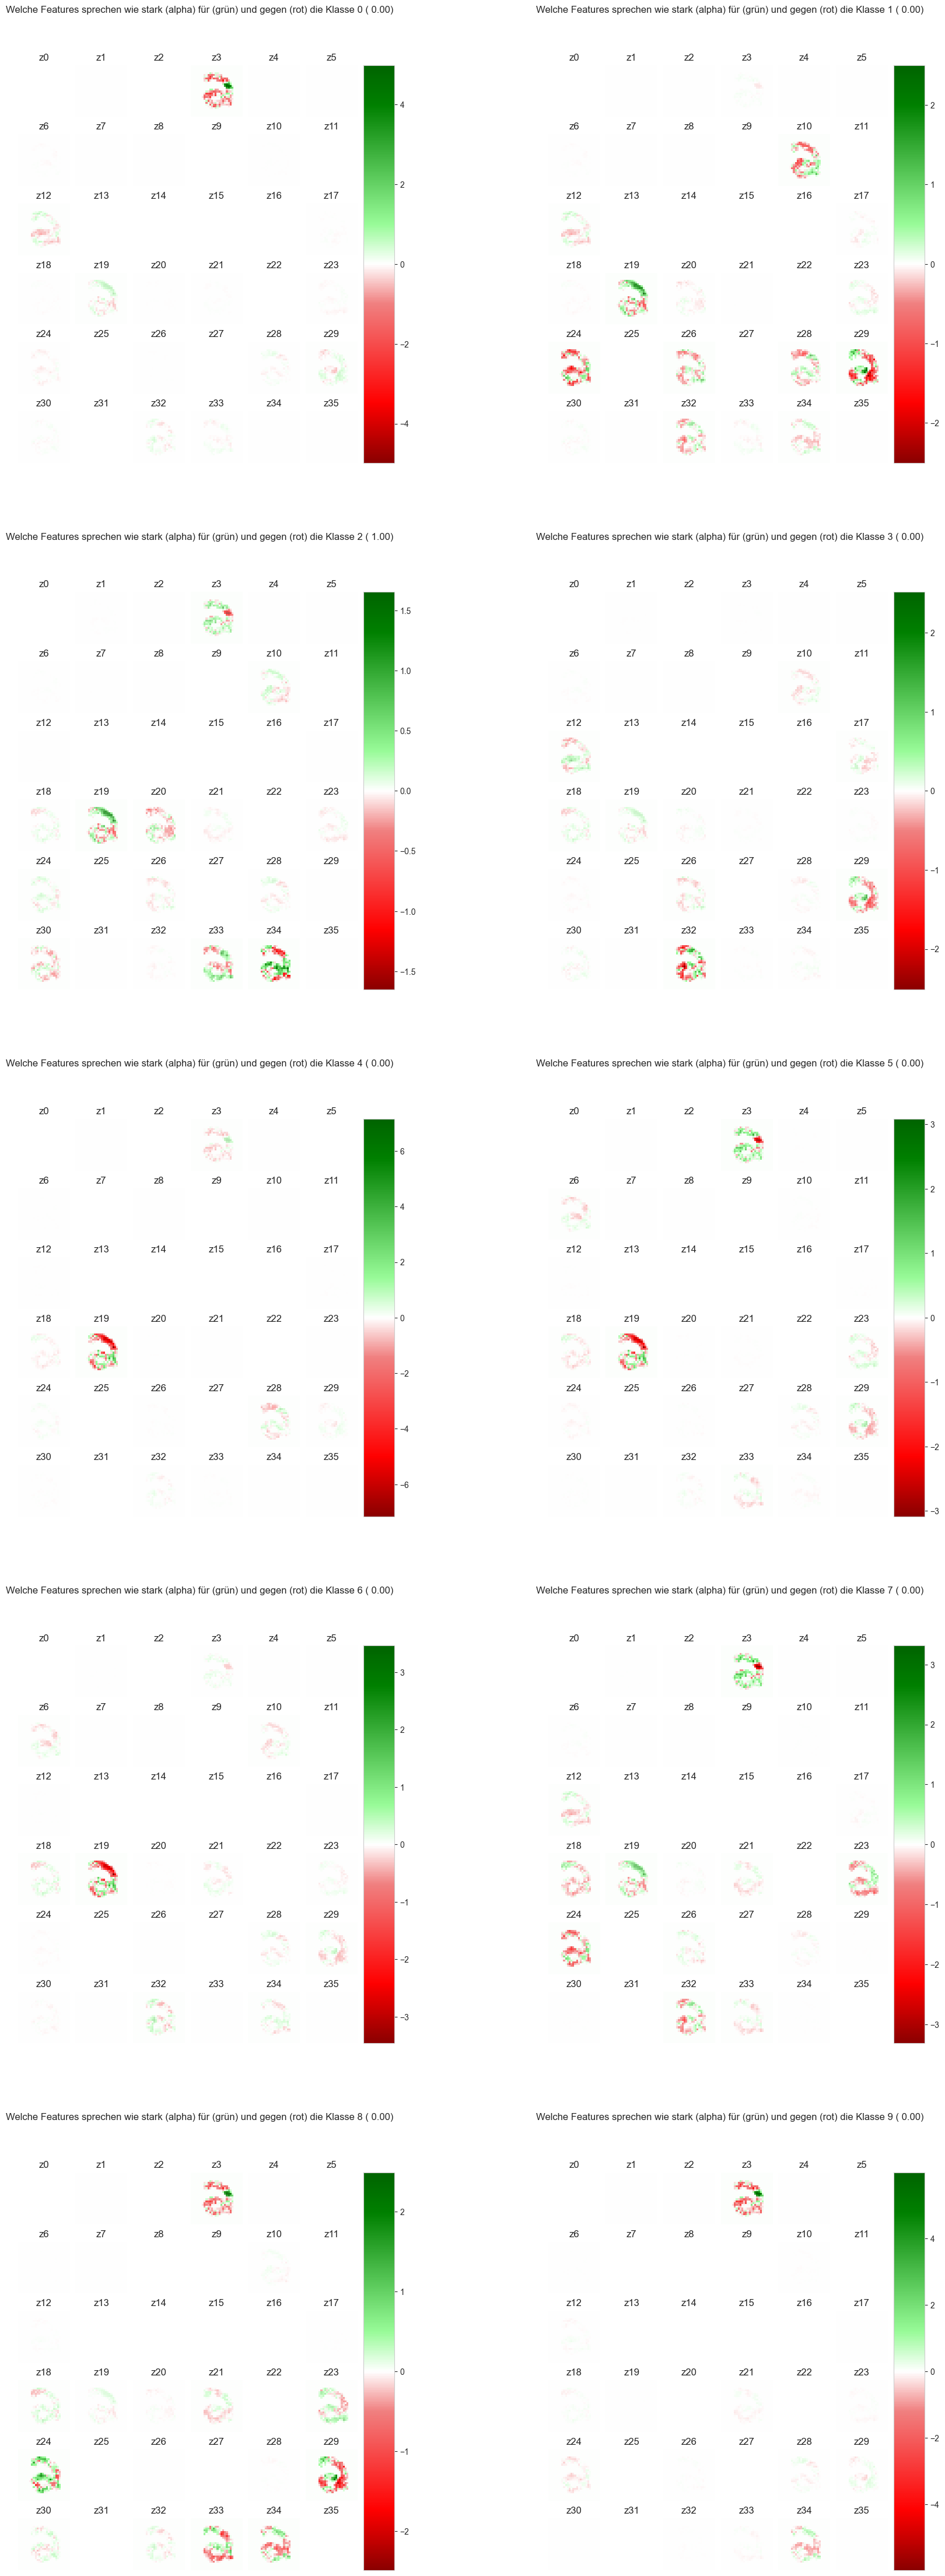

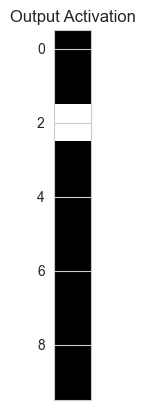

In [45]:
# Welches Bild wir nehmen, kann auf 0, 1, 2, ... gesetzt werden, um andere Bilder zu plotten / analysieren.
image_index = 10

# Berechnung der Aktivierungen innerhalb des Neuralen Netzes für spätere plots.
input_layer_output, hidden_layer_output, output_layer_output = get_layer_activations_for(model_with_hl, X_val[image_index, :])

fig = plt.figure(constrained_layout=True, figsize=(18, 9))
subfigs = fig.subfigures(1, 2, width_ratios=[1, 3])
left_fig = subfigs[0]
ax = left_fig.subplots(1, 1)

# Plotten vom Input Image
# subfigs[0].title("Input image")
ax.imshow(input_layer_output.reshape(28, 28), cmap='gray')
ax.axis('off')

hidden_layer_pre_output = (model_with_hl.get_weights()[0].T * input_layer_output).T

# Plotten von der Aktivierung vom Hidden Layer
# Welche gelernten Features sind für diese Input-Bild aktiv.
right_fig = subfigs[1]
right_fig = plot_weights(hidden_layer_pre_output, lambda i: f"z{i}", alphas=np.abs(hidden_layer_output) / np.max(np.abs(hidden_layer_output)), fig=right_fig)
right_fig.suptitle(f"Welche Features sind für das Bild aktiv?")
plt.show()

# Für jedes Output Neuron (0-9) plotten wir die 36 gelernten Features absteigend.
# Positive Aktivierungen sprechen für diesen Output (z.B. für die Ziffer 0).
# Negative Aktivierungen sprechen gegen diesen Output (z.B. gegen die Ziffer 0).
# Die Features wurden transparent gemacht, wenn sie keine grosse Rolle spielen.

fig = plt.figure(constrained_layout=True, figsize=(9*2, 9*5))
subfigs = fig.subfigures(5, 2)

for i, ax in zip(range(0, 10), subfigs.flatten()):
    hidden_layer_output_weighted = hidden_layer_output * model_with_hl.get_weights()[2][:, i]
    xx = hidden_layer_pre_output * hidden_layer_output_weighted
    # fig = plt.figure(figsize=(8, 8))
    fig = plot_weights(xx, lambda i: f"z{i}", alphas=np.abs(hidden_layer_output_weighted) / np.max(np.abs(hidden_layer_output_weighted)), fig=ax)
    fig.suptitle(f"Welche Features sprechen wie stark (alpha) für (grün) und gegen (rot) die Klasse {i} ({output_layer_output[i]: .2f})")

plt.show()

# Plotten von der Aktivierung vom Output Layer (welche Ziffer predicten wir)
fig, ax = plt.subplots()
plt.title("Output Activation")
ax.xaxis.set_visible(False)
ax.imshow(output_layer_output.reshape(10, 1), cmap='gray')
plt.show()

2\.
Die richtige Klasse hat viele positive aktive Features, darum wird auch diese Klasse vorhergesagt.

## (Extra) Aufgabe 3 - CNN

Mit Bildern werden im Deep Learning oft `Convolutional Neural Networks` (`CNN`) eingesetzt.

CNNs sind laut Drehbuch nicht Teil vom Inhalt von diesem Modul, für interessierte zeigt diese Aufgabe wie man sie einsetzt.  

Anders als beim Feed-Forward Neural Network (Aufgabe 2) legen wir nicht Masken über den gesamten Input sondern legen eine kleine Maske (z.B. 3*3 Pixel) und sliden diese über das gesamte Bild. Die Output-Werte dieses Verfahrens sind dann die Aktivierungen (Features) dieser Maske an den verschiedenen Stellen im Bild. 

Mehr zu CNNs finden Sie hier: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

1. Machen Sie ein Modell mit `tf.keras.layers.Conv2D` Layers.

In [46]:
# Neural Network mit zwei Hidden Convolution Layers
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1), name='input_layer'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=tf.keras.activations.gelu, name='hidden_layer_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=tf.keras.activations.gelu, name='hidden_layer_2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'),
    tf.keras.layers.Softmax()
])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Conv2D)     (None, 13, 13, 32)        320       
                                                                 
 hidden_layer_2 (Conv2D)     (None, 6, 6, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 output_layer (Dense)        (None, 10)                11530     
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                                 
Total params: 21,098
Trainable params: 21,098
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [48]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [49]:
"""
Without GPU (or TPU :D) support, this may take a while.
Convolutions on CPUs (in tensorflow) are quit slow.
Note that this model has less total parameters than Aufgabe 2.
"""

X_train_sq = X_train.reshape(-1, 28, 28, 1)
X_val_sq = X_val.reshape(-1, 28, 28, 1)

history = model.fit(X_train_sq, y_train, batch_size=128, epochs=15, validation_data=(X_val_sq, y_val))

Epoch 1/15


/Users/mebr/PycharmProjects/cas_machine-learning-exercise/venv/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 4s 8ms/step - loss: 1.6300 - accuracy: 0.8555 - val_loss: 1.5406 - val_accuracy: 0.9252
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 1.5260 - accuracy: 0.9375 - val_loss: 1.5159 - val_accuracy: 0.9476
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 1.5076 - accuracy: 0.9561 - val_loss: 1.5006 - val_accuracy: 0.9622
Epoch 4/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4967 - accuracy: 0.9667 - val_loss: 1.4947 - val_accuracy: 0.9688
Epoch 5/15
469/469 [==============================] - 4s 8ms/step - loss: 1.4905 - accuracy: 0.9722 - val_loss: 1.4903 - val_accuracy: 0.9730
Epoch 6/15
469/469 [==============================] - 4s 7ms/step - loss: 1.4865 - accuracy: 0.9763 - val_loss: 1.4868 - val_accuracy: 0.9754
Epoch 7/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4840 - accuracy: 0.9782 - val_loss: 1.4868 - val_accuracy: 0.9752
Epoch 8/15
469/46

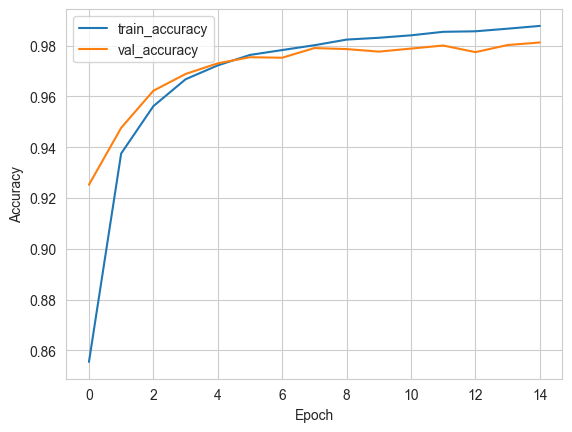

In [50]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
y_val_hat_prob = model.predict(X_val_sq)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 1ms/step
0.9812


Wir erreichen eine höhere Genauigkeit als in Aufgabe 2, haben aber weniger Parameter als in Aufgabe 2 im Neuralen Netz. Durch die andere Struktur des Netzwerkes nutzen wir die Parameter besser für den Bild-Task.

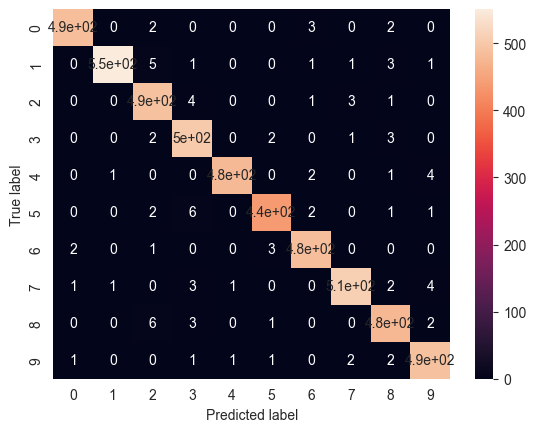

In [52]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, labels=clf.classes_),
        columns=[clf.classes_], # Name columns
        index=[clf.classes_] # Name rows
    ),
    annot=True # Show numbers in heatmap (not just colors)
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()


## Schlusswort Aufgabenblatt 4

Deep Learning ist ein sehr grosses Teilgebiet von Machine Learning.

Grundsätzlich funktionieren Neurale Netze gut, wenn man **viele Daten** hat und `Feature Engineering` schwierig ist:
 * Classification auf Bilder
 * Sprach-Erkennung (Natural Language Processing)
 * Reinforcement-Learning

Das Netzwerk lernt (anhand von Unmengen an Daten) während dem Training Strukturen, die Helfen, die `Kostenfunktion` zu minimieren.
Man kann dies als eine Art automatisches `Feature Engineering` sehen - mit genügend und sauberen Daten meist besser als es ein Mensch je hätte machen können.

### MNIST

Der MNIST Datensatz ist ein sehr bekannter Datensatz. 
Hier gibt eine Referenz die verschiedene Lösungsansätze und deren Performanz aufzeigt: http://yann.lecun.com/exdb/mnist/

### Ein Modell-Framework

`Neurale Netze` kann man auch als **ein Modell-Framework** betrachten:

* Es ist einfach das Modell mächtiger zu machen (mehr Neuronen, mehr Layers), wenn man genügend Daten hat um nicht zu `overfitten`.
* Die Anordnung der Neuronen (Architektur des Neuralen Netzes) kann dem Netzwerk beim Lernen helfen.
  * Feed Forward Neural Network haben wir im Theory Teil kennengelernt (Aufgabe 2), aber es gibt viele weitere: RNN, CNN (Aufgabe 3), Residual Connections, Transformers, Inception, Multi-Task Learning etc.)
  * Architekturen treffen meistens Annahmen über das zugrundeliegende Problem und haben daher verschiedene Vor- und Nachteile.